In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matrixprofile as mp
import seaborn as sns

def mprofile(ts):
    profile = mp.compute(ts, windows=48)
    figures = mp.visualize(profile)
    ax = plt.gca()
    ax.set_title(f'Matrix profile, 1 day window')

In [2]:
data = pd.read_csv('lv_data.csv', index_col=0).to_numpy()
norm_data = (data - np.mean(data, axis=1)[:, np.newaxis]) / np.std(data, axis=1)[:, np.newaxis]
norm_data

array([[-0.5897838 , -0.95193646, -1.0831769 , ..., -0.26702692,
        -0.04124607, -0.60007021],
       [ 0.72355091, -0.05017207, -0.39508472, ..., -0.33682244,
        -0.91556102, -1.05072949],
       [-0.50706511, -0.42187561, -0.45123145, ..., -0.12636279,
        -0.62636255, -1.02703701],
       ...,
       [-1.05634376,  0.28547533,  0.97156021, ..., -1.00739475,
        -1.26925485, -1.69256683],
       [-0.04643146, -0.56048694, -0.48086632, ...,  0.64912812,
        -0.36568697, -0.6074863 ],
       [-0.69081118, -0.64554899, -0.77180666, ...,  0.54651396,
         0.51435398,  0.02445042]])

In [3]:
daily_data = norm_data.reshape((1642 * 31, 48))
daily_data

array([[-0.5897838 , -0.95193646, -1.0831769 , ..., -0.5901385 ,
        -0.49968902, -0.90440614],
       [-0.92285074, -1.04600393, -1.23768591, ..., -0.42593426,
        -0.49413199, -0.67588226],
       [-1.04501076, -1.08606182, -1.10195256, ..., -0.46797849,
        -0.96721238, -0.80367024],
       ...,
       [-0.46438115, -0.94249273, -0.88138879, ..., -0.49010913,
        -0.73881291, -0.85137281],
       [-1.00145268, -1.01753267, -0.95964472, ..., -0.44186917,
        -0.32930927, -0.82242884],
       [-0.38934122, -0.95642872, -1.02825266, ...,  0.54651396,
         0.51435398,  0.02445042]])

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
data_tensor = torch.tensor(daily_data, dtype=torch.float32)
device_data = data_tensor.to(device)

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [40]:
def reconstruction_plot(index):
    sample_data = device_data[index]
    encoded_data = model.encoder(sample_data)
    reconstructed_data = model.decoder(encoded_data).cpu().detach().numpy()
    plt.plot(daily_data[index])
    plt.plot(reconstructed_data)
    ax = plt.gca()
    ax.set_title(f'Error {round(np.linalg.norm(daily_data[index] - reconstructed_data), 2)}')


def full_reconstruction_plot(index):
    reconstructed_ts = np.zeros(1488)
    mse = np.zeros(31)
    for i in range(31):
        sample_data = device_data[index * 31 + i]
        encoded_data = model.encoder(sample_data)
        reconstructed_data = model.decoder(encoded_data).cpu().detach().numpy()
        reconstructed_ts[48 * i:48 * (i + 1)] = reconstructed_data
        mse[i] = np.linalg.norm(daily_data[index * 31 + i] - reconstructed_data)
    plt.plot(norm_data[index])
    plt.plot(reconstructed_ts)
    ax = plt.gca()
    ax.set_title(f'Average Error {round(mse.mean(), 2)}')
    fig = plt.gcf()
    fig.set_figwidth(20)


def get_reconstructed_data():
    reconstructed_data = np.zeros((50902, 48))
    for i in range(50902):
        sample_data = device_data[i]
        encoded_data = model.encoder(sample_data)
        reconstructed_data[i] = model.decoder(encoded_data).cpu().detach().numpy()
    return reconstructed_data

In [8]:
# Параметры модели и обучения
input_dim = 48  # Размерность входных данных (длина каждой подпоследовательности)
encoding_dim = 5  # Размерность скрытого представления
learning_rate = 0.00001
batch_size = 32
num_epochs = 300

In [9]:
from torch.optim import lr_scheduler

# Создание DataLoader для загрузки данных в модель
data_loader = DataLoader(TensorDataset(device_data), batch_size=batch_size, shuffle=True)

# Создание модели
model = Autoencoder(input_dim, encoding_dim).to(device)

# Определение функции потерь и оптимизатора
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

In [10]:
model.load_state_dict(torch.load('first_autoencoder.pth'))

<All keys matched successfully>

In [ ]:
# Список для сохранения значений функции потерь
losses = []

# Обучение модели
for epoch in range(num_epochs):
    loss = -1
    for batch in data_loader:
        input_data = batch[0]
        optimizer.zero_grad()
        reconstructed = model(input_data)
        loss = criterion(reconstructed, input_data)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    scheduler.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Построение графика
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

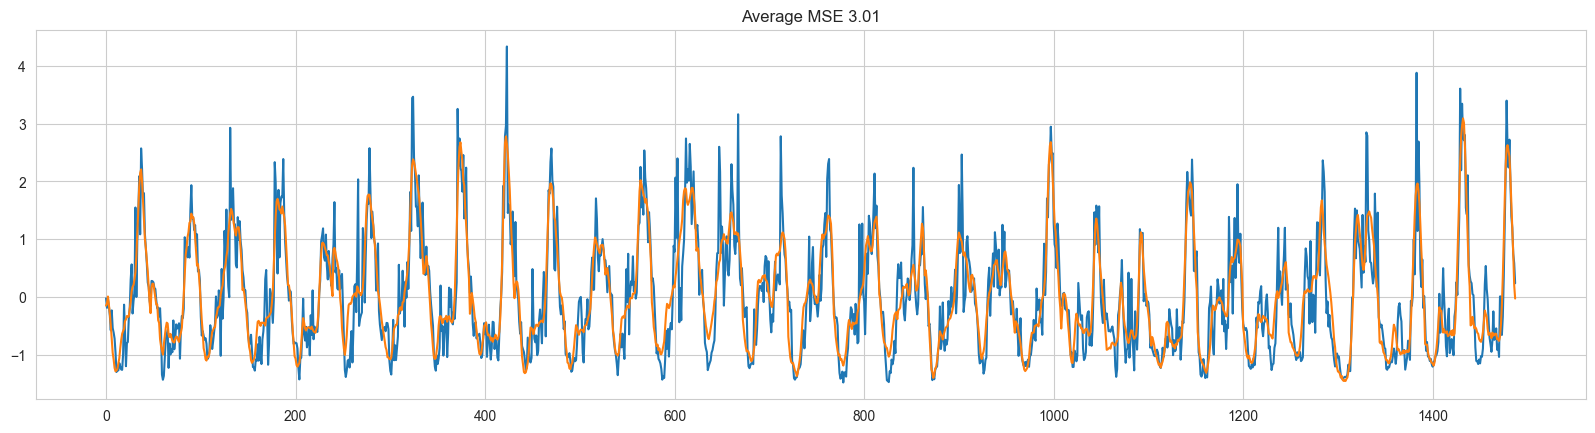

In [39]:
full_reconstruction_plot(450)

In [11]:
reconstructed_data = get_reconstructed_data()
reconstructed_data

array([[-0.78493881, -0.90513796, -1.00811636, ..., -0.27268791,
        -0.41593927, -0.62424242],
       [-0.84997046, -0.9835915 , -1.07735145, ..., -0.20036341,
        -0.41623095, -0.65047675],
       [-0.81537771, -0.94286656, -1.03362882, ..., -0.11474119,
        -0.37456208, -0.60120434],
       ...,
       [-0.94557095, -1.06018853, -1.14339328, ..., -0.47126436,
        -0.71067476, -0.81979972],
       [-0.84754086, -0.98762172, -1.06233919, ..., -0.20726715,
        -0.42046288, -0.63219291],
       [-0.75097692, -0.89316964, -1.06021225, ...,  0.33093739,
        -0.04613541, -0.33619922]])

In [12]:
daily_data

array([[-0.5897838 , -0.95193646, -1.0831769 , ..., -0.5901385 ,
        -0.49968902, -0.90440614],
       [-0.92285074, -1.04600393, -1.23768591, ..., -0.42593426,
        -0.49413199, -0.67588226],
       [-1.04501076, -1.08606182, -1.10195256, ..., -0.46797849,
        -0.96721238, -0.80367024],
       ...,
       [-0.46438115, -0.94249273, -0.88138879, ..., -0.49010913,
        -0.73881291, -0.85137281],
       [-1.00145268, -1.01753267, -0.95964472, ..., -0.44186917,
        -0.32930927, -0.82242884],
       [-0.38934122, -0.95642872, -1.02825266, ...,  0.54651396,
         0.51435398,  0.02445042]])

In [13]:
deviation = np.linalg.norm(reconstructed_data - daily_data, axis=1)
deviation

array([1.6439563 , 2.18141872, 2.31690322, ..., 3.51614211, 3.87623764,
       3.38615099])

In [14]:
deviation.mean()

3.2076414901013592

In [15]:
# 3.2076414901013592 5
# 3.380945643772159  4
# 3.3923897412977464 4
# 3.4673022858212366 4
# 3.539121524193781 4
# 3.5252530220733718 4

SyntaxError: invalid syntax (4258949197.py, line 1)

Подход 1, ищем максимальные локальные ошибки аппроксимации

In [19]:
local_max_metric = -np.sort(-deviation)
local_max_index = np.argsort(-deviation)
local_max = np.column_stack((local_max_index // 31, local_max_metric))
local_max

array([[4.63000000e+02, 1.60777842e+01],
       [6.03000000e+02, 1.19631402e+01],
       [7.42000000e+02, 1.10337140e+01],
       ...,
       [1.47000000e+03, 4.73836755e-01],
       [1.47000000e+03, 4.73836755e-01],
       [1.47000000e+03, 4.73836755e-01]])

<Axes: >

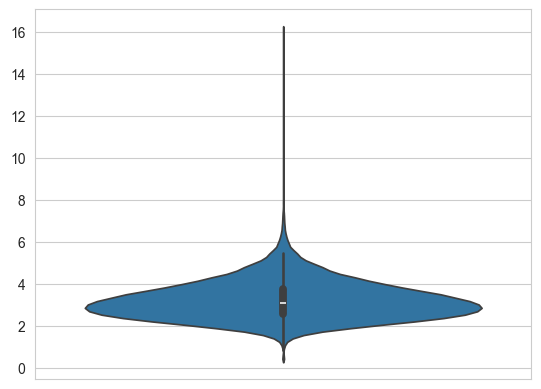

In [17]:
sns.violinplot(-np.sort(-deviation))

In [18]:
np.quantile(local_max_metric, 0.9)

4.400362526134828

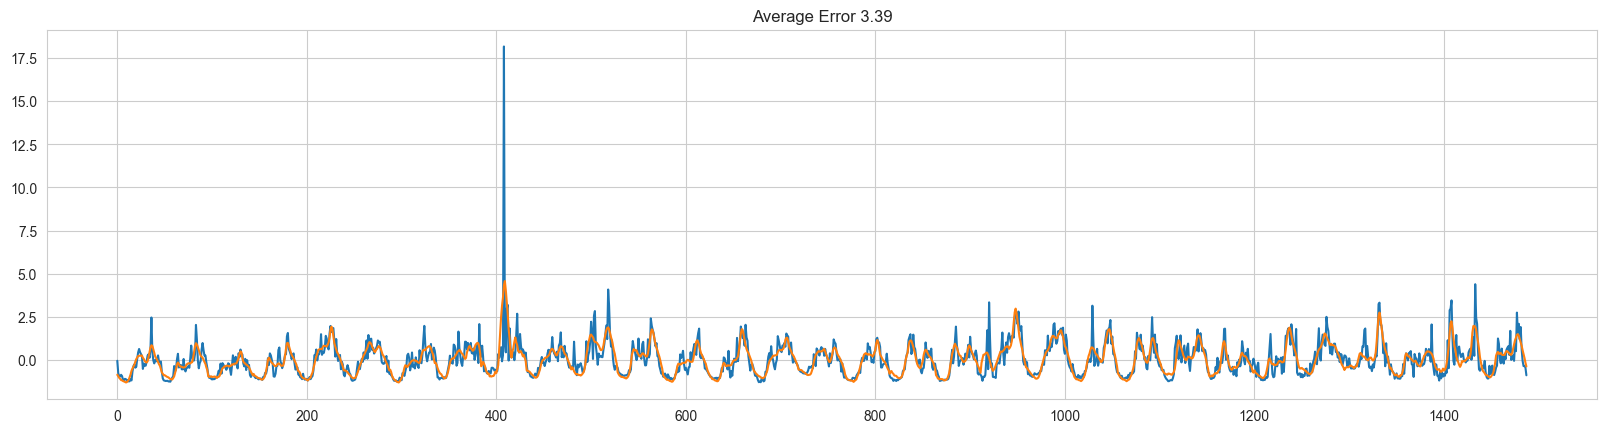

In [41]:
full_reconstruction_plot(463)

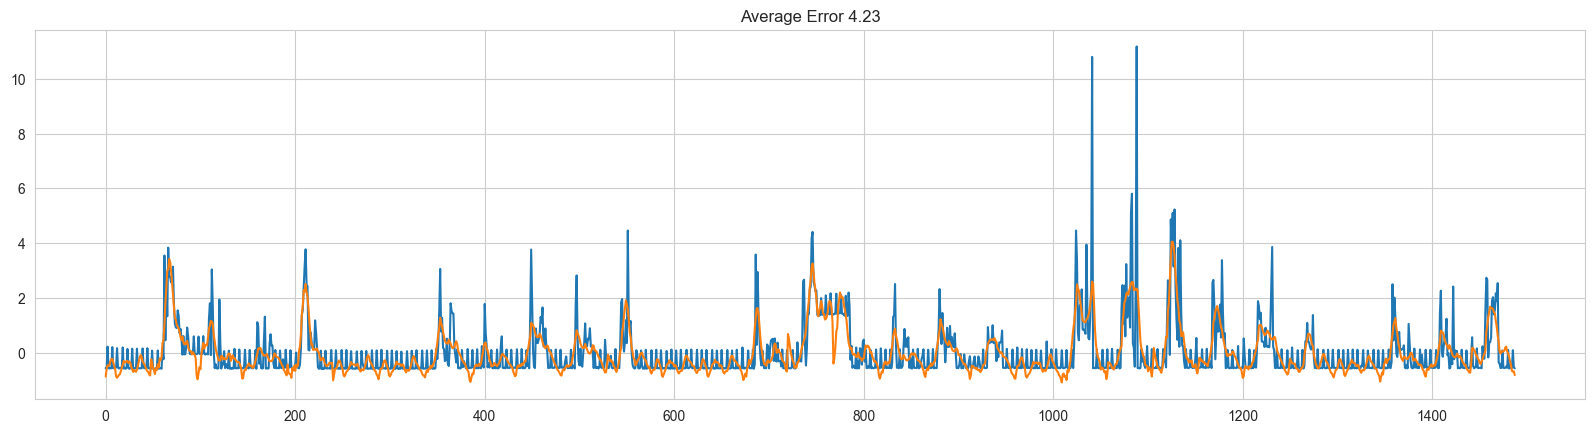

In [42]:
full_reconstruction_plot(603)

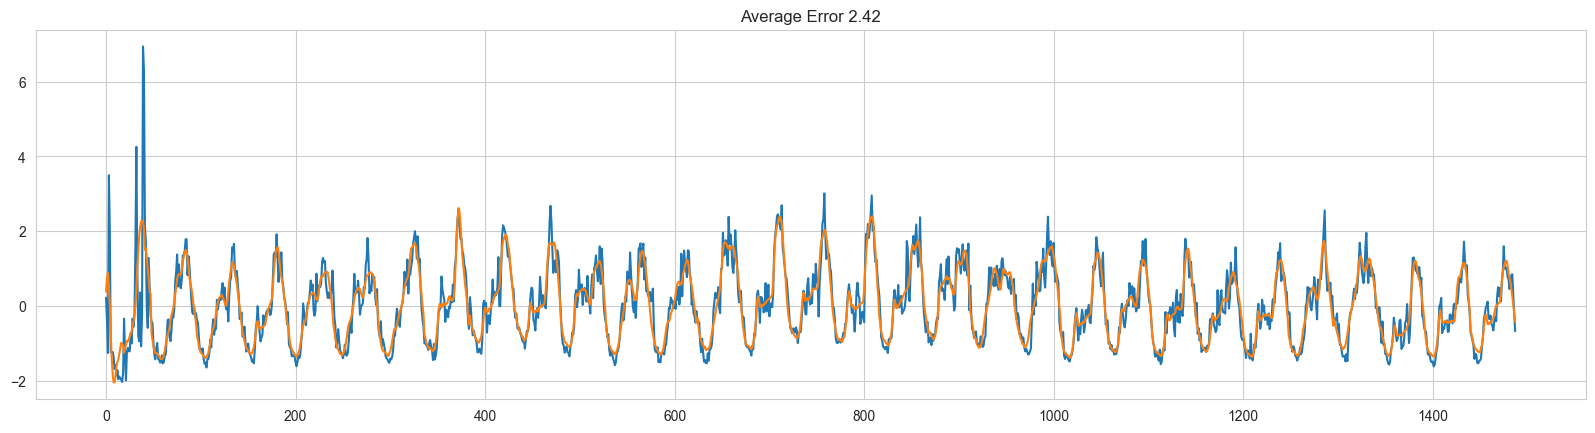

In [43]:
full_reconstruction_plot(742)

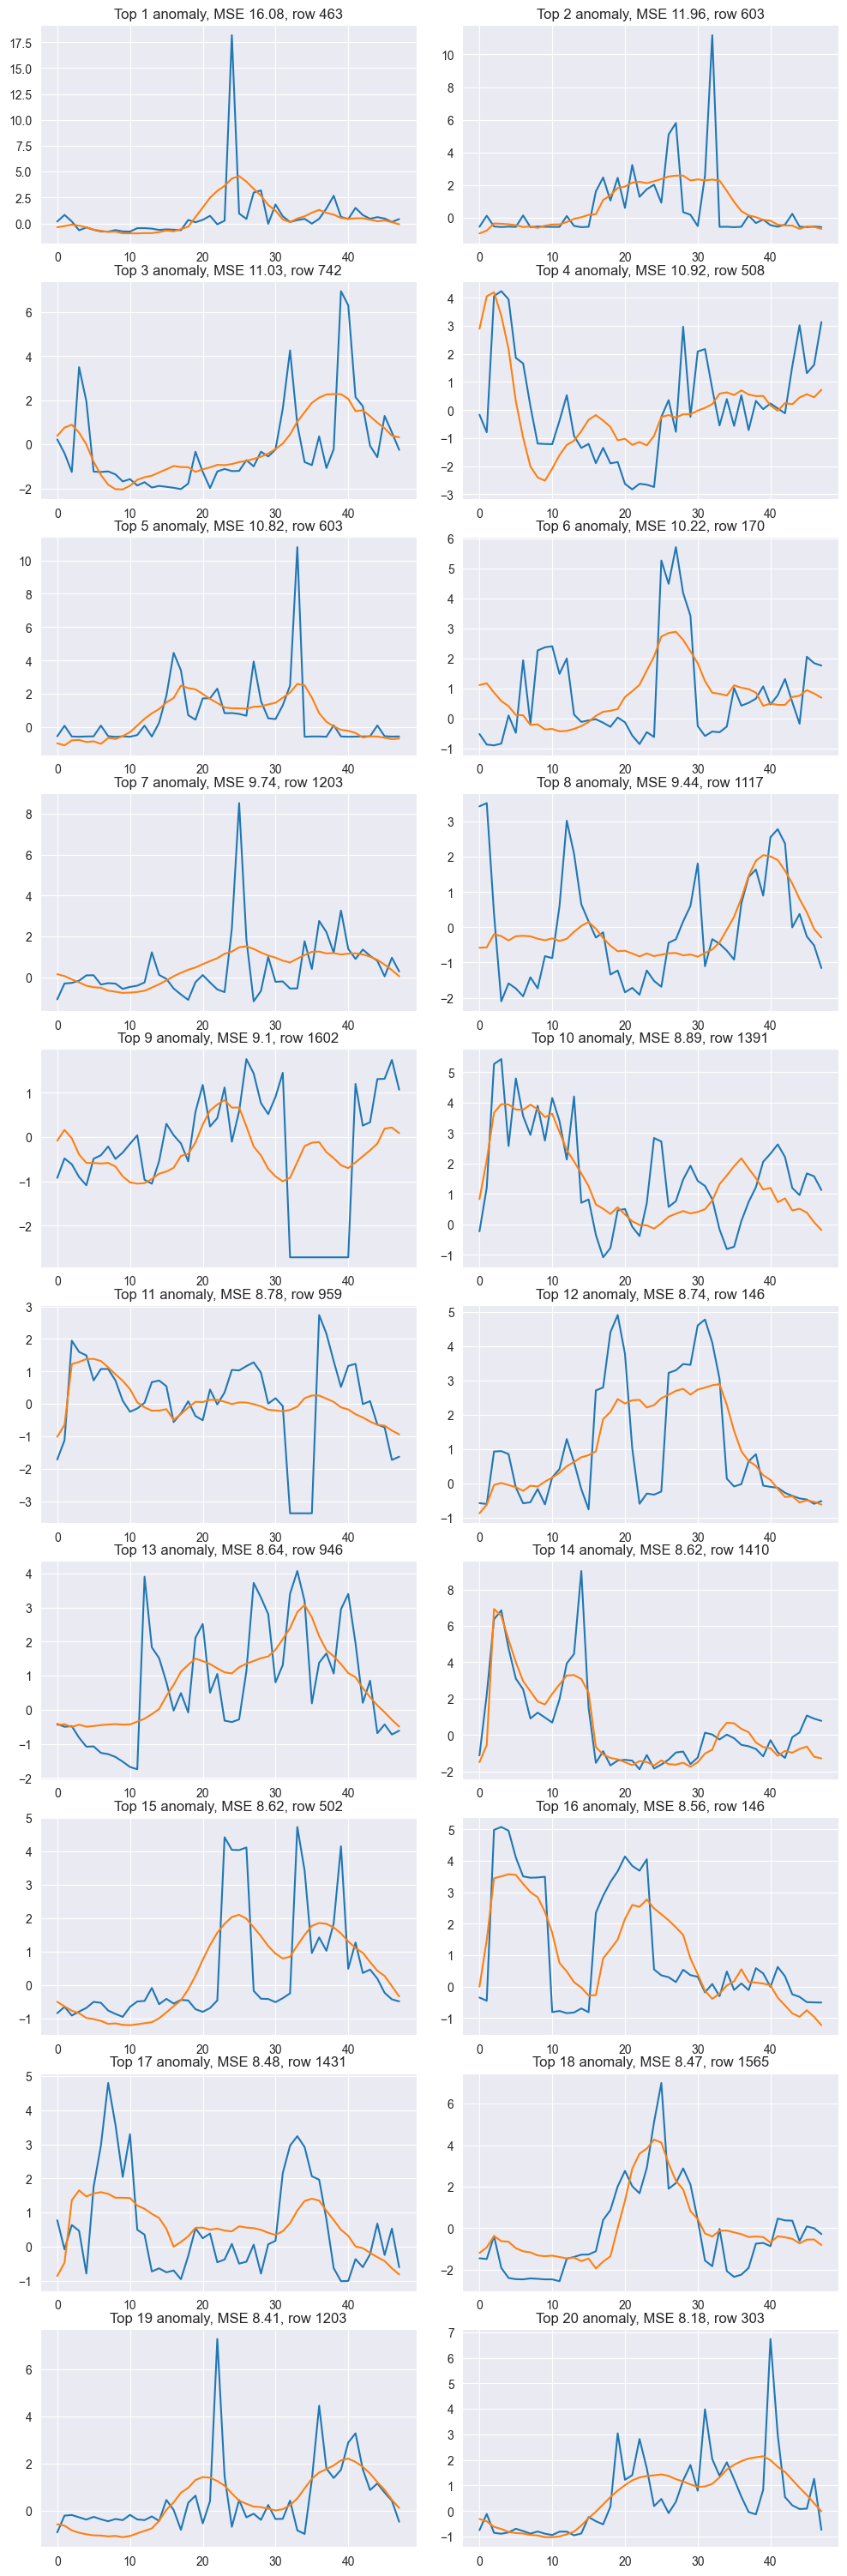

In [18]:
fig, axs = plt.subplots(10, 2, figsize=(10, 30))
plt.tight_layout()
for i in range(20):
    axs[i // 2, i % 2].plot(daily_data[local_max_index[i]])
    axs[i // 2, i % 2].plot(reconstructed_data[local_max_index[i]])
    axs[i // 2, i % 2].set_title(f'Top {i + 1} anomaly, MSE {round(local_max_metric[i], 2)}, row {local_max_index[i] // 31}')
plt.show()

Подход 2, средние ошибки аппроксимации на ряду вцелом

In [23]:
mean_deviation = np.mean(deviation.reshape((1642, 31)), axis=1)
mean_deviation

array([2.16182994, 3.45284048, 1.93492897, ..., 3.91203992, 3.43264309,
       3.50447572])

In [24]:
mean_max_metric = -np.sort(-mean_deviation)
mean_max_index = np.argsort(-mean_deviation)
mean_max = np.column_stack((mean_max_index, mean_max_metric))
mean_max

array([[8.78000000e+02, 5.37648426e+00],
       [2.80000000e+01, 5.24816046e+00],
       [1.20300000e+03, 5.18013393e+00],
       ...,
       [1.09000000e+02, 1.39367816e+00],
       [1.33700000e+03, 1.30977425e+00],
       [2.23000000e+02, 1.17137265e+00]])

<Axes: >

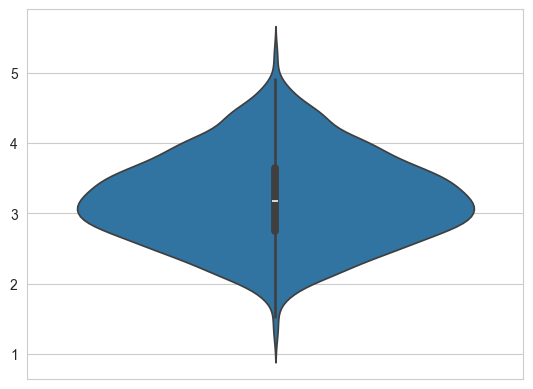

In [44]:
sns.violinplot(mean_max_metric)

In [25]:
np.quantile(mean_max_metric, 0.9)

4.072764060607094

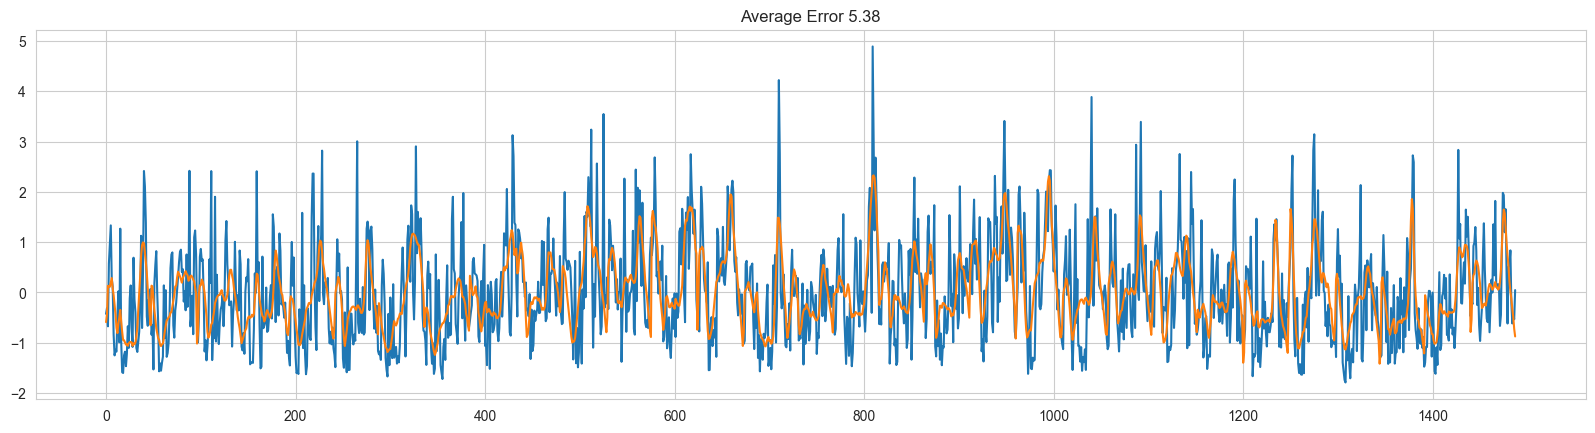

In [45]:
full_reconstruction_plot(878)

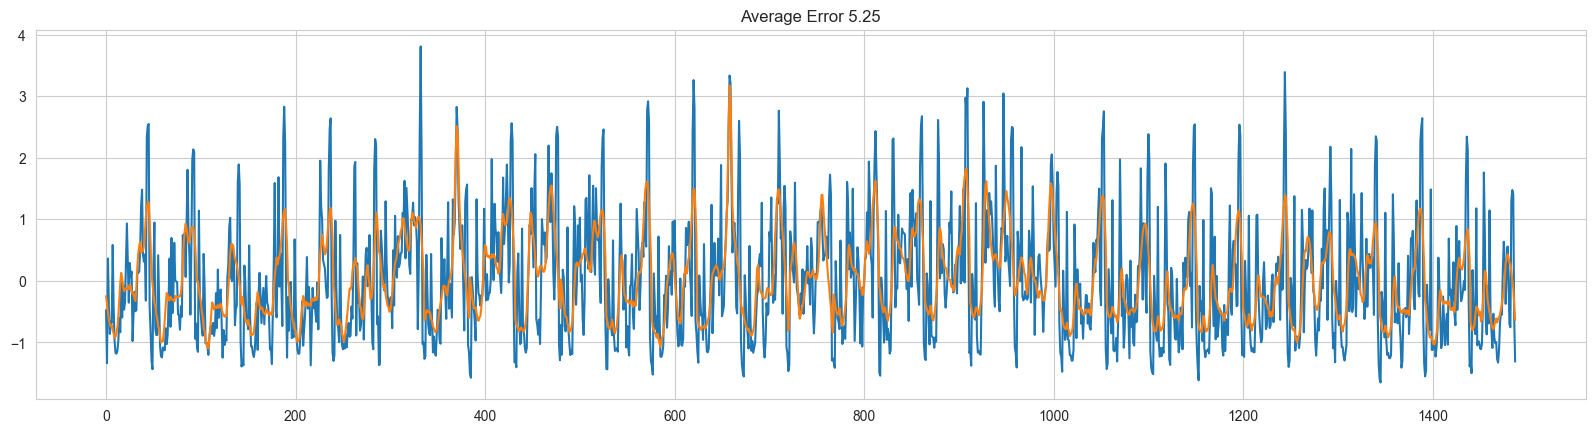

In [46]:
full_reconstruction_plot(28)

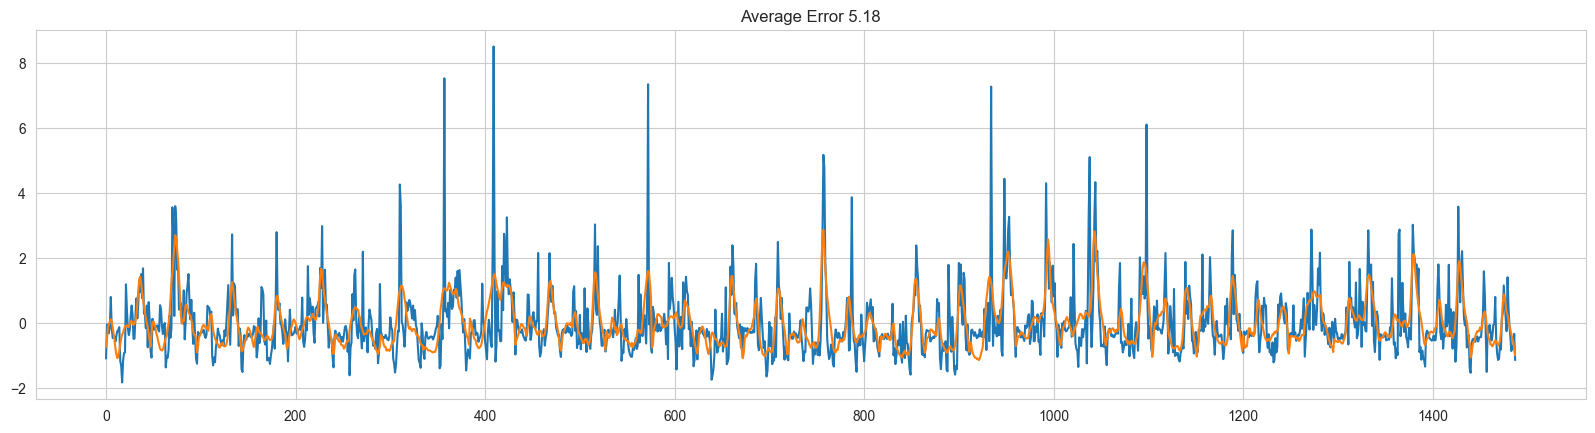

In [47]:
full_reconstruction_plot(1203)

In [31]:
# Save the model
# torch.save(model.state_dict(), 'first_autoencoder.pth')

In [26]:
encoded_data = np.zeros((50902, 5))
with torch.no_grad():
    for i in range(50902):
        encoded = model.encoder(device_data[i])
        encoded_data[i] = encoded.cpu().numpy()
encoded_data

array([[-0.01340682, -0.20816119,  0.54887038, -0.37018114, -2.11408234],
       [ 0.86465454, -0.62152535,  0.64347261, -0.55488855, -2.27868462],
       [ 1.20228243, -0.61346322,  0.61042553, -0.90817893, -1.81954384],
       ...,
       [ 1.10399866,  0.12577939, -0.13895187, -0.29096675, -1.38005996],
       [ 1.15686643, -0.29298472,  0.79750812, -0.78571129, -1.96626186],
       [ 1.58006608, -1.61165917, -0.20477515,  0.10358295, -1.72136033]])

In [48]:
from sklearn.cluster import DBSCAN

# Создаем объект DBSCAN
dbscan = DBSCAN(eps=2.25, min_samples=5)

# Проводим кластеризацию данных
clusters = dbscan.fit_predict(encoded_data)

# Ищем объекты, отнесенные к кластеру -1 (это аномалии)
anomalies_indices = np.where(clusters == -1)[0]

In [49]:
np.unique(clusters)

array([-1,  0], dtype=int64)

In [50]:
len(anomalies_indices)

19

In [51]:
# Преобразуем массив данных в DataFrame
df = pd.DataFrame(encoded_data, columns=['Dim1', 'Dim2', 'Dim3', 'Dim4', 'Dim5'])

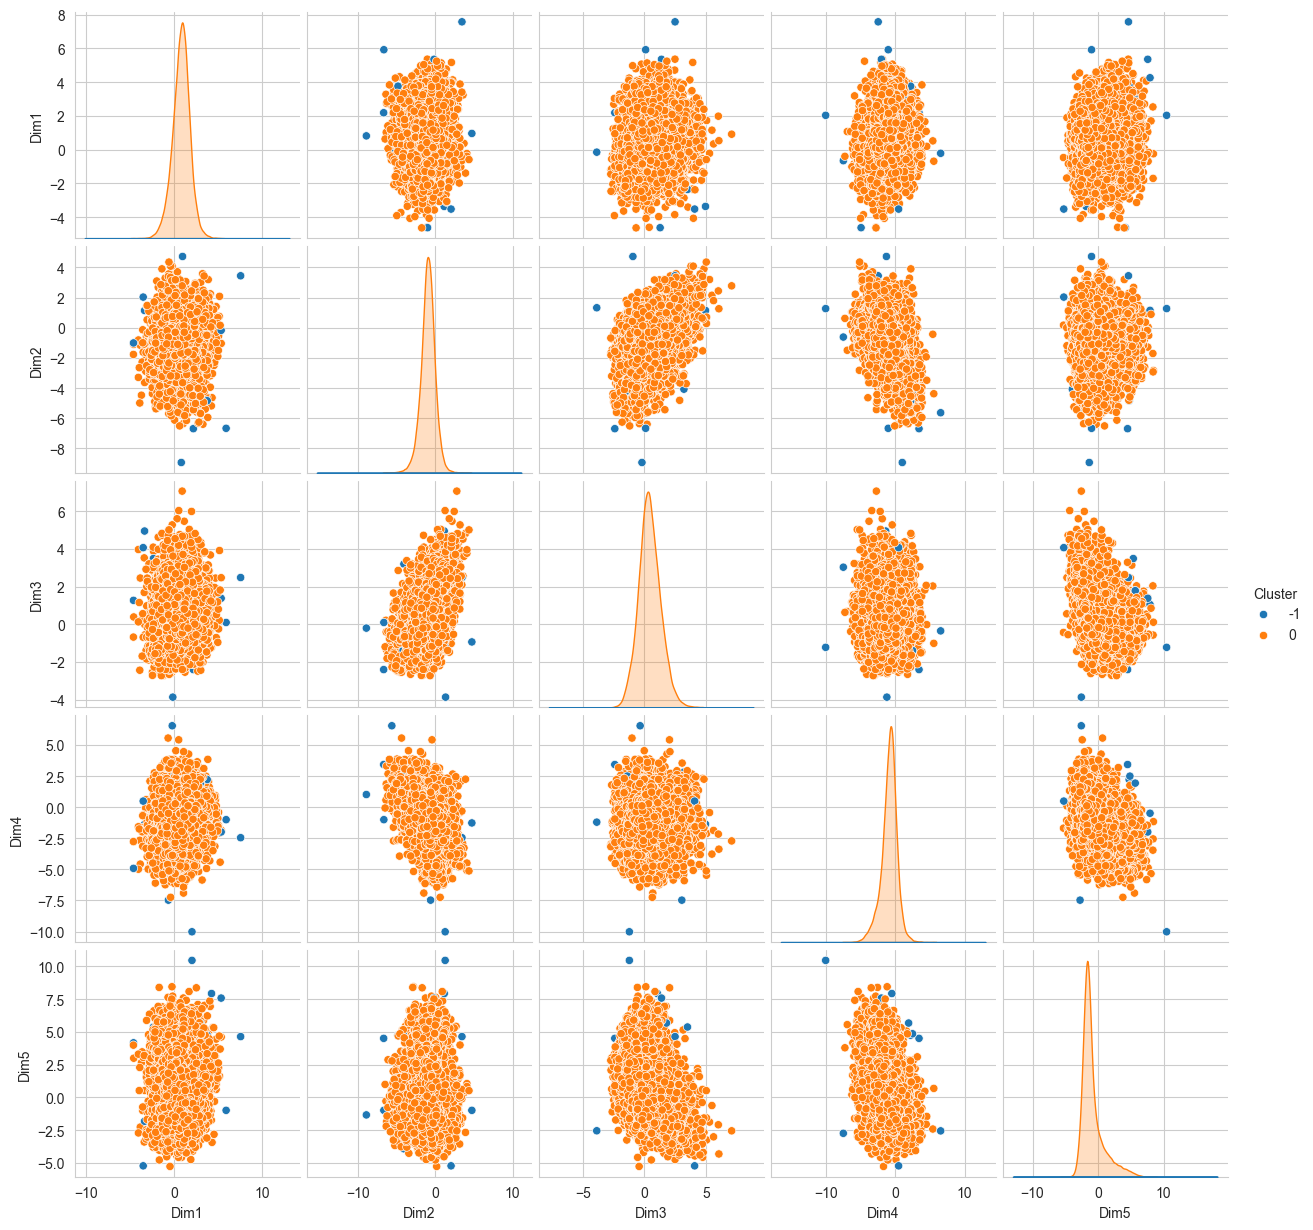

In [52]:
# Добавляем столбец 'Cluster', содержащий метки кластеров
df['Cluster'] = clusters

# Создаем pairplot, выделяя разные кластеры цветом
sns.pairplot(df, hue='Cluster', palette='tab10')
plt.show()

In [53]:
anomalies_indices

array([ 3792,  4532,  4543, 12224, 12928, 15141, 17807, 18118, 30070,
       33941, 35438, 43125, 43370, 43710, 44381, 44458, 46907, 48515,
       49017], dtype=int64)

In [54]:
anomalies_indices // 31

array([ 122,  146,  146,  394,  417,  488,  574,  584,  970, 1094, 1143,
       1391, 1399, 1410, 1431, 1434, 1513, 1565, 1581], dtype=int64)

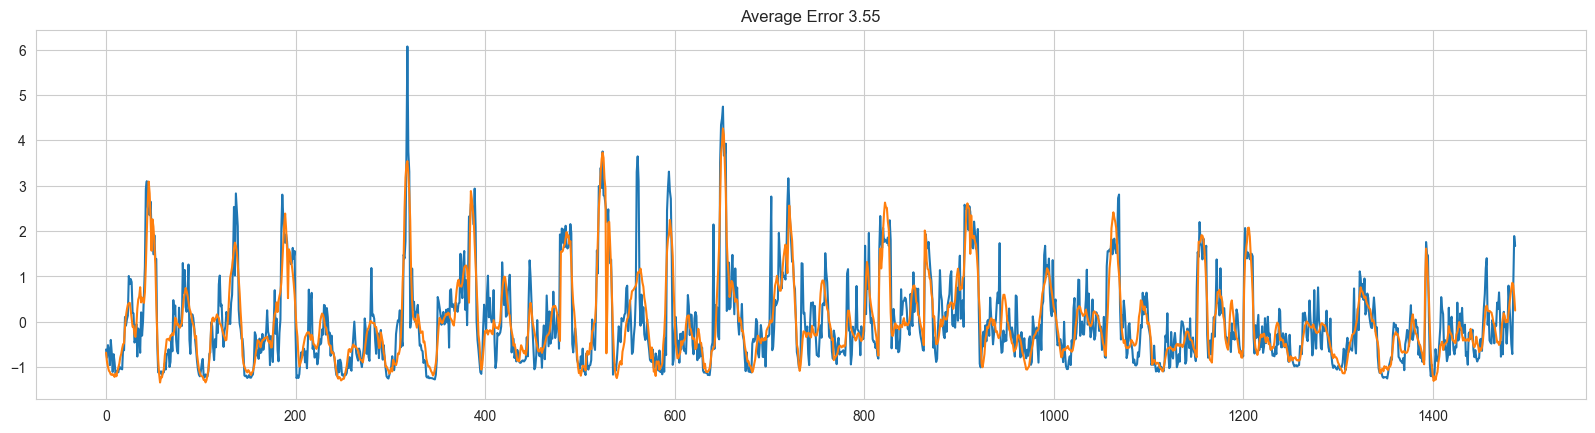

In [55]:
full_reconstruction_plot(122)

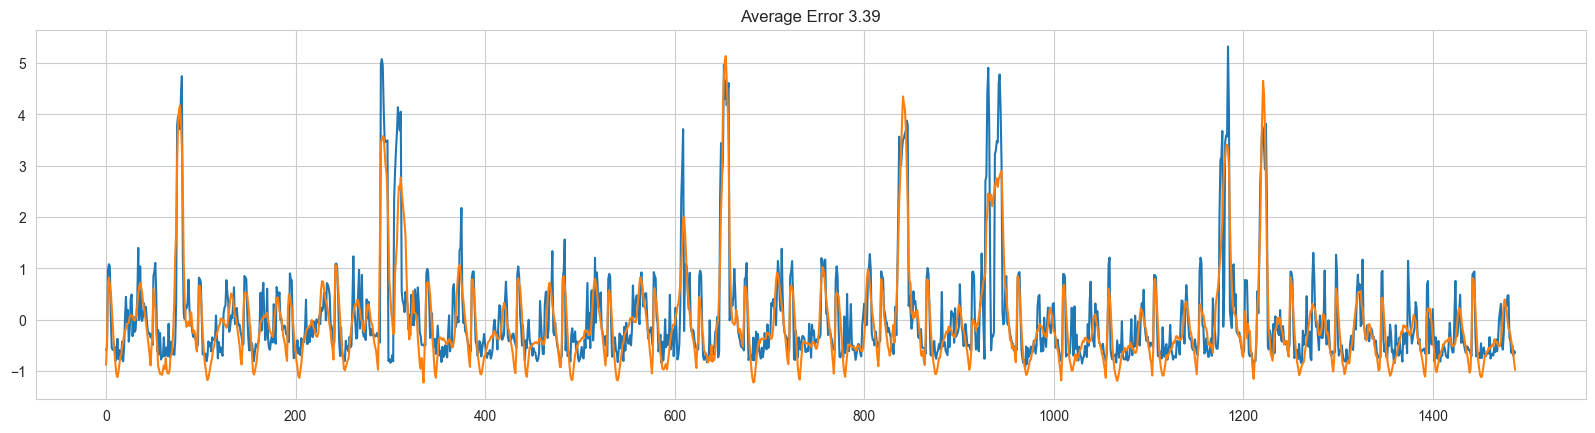

In [56]:
full_reconstruction_plot(146)

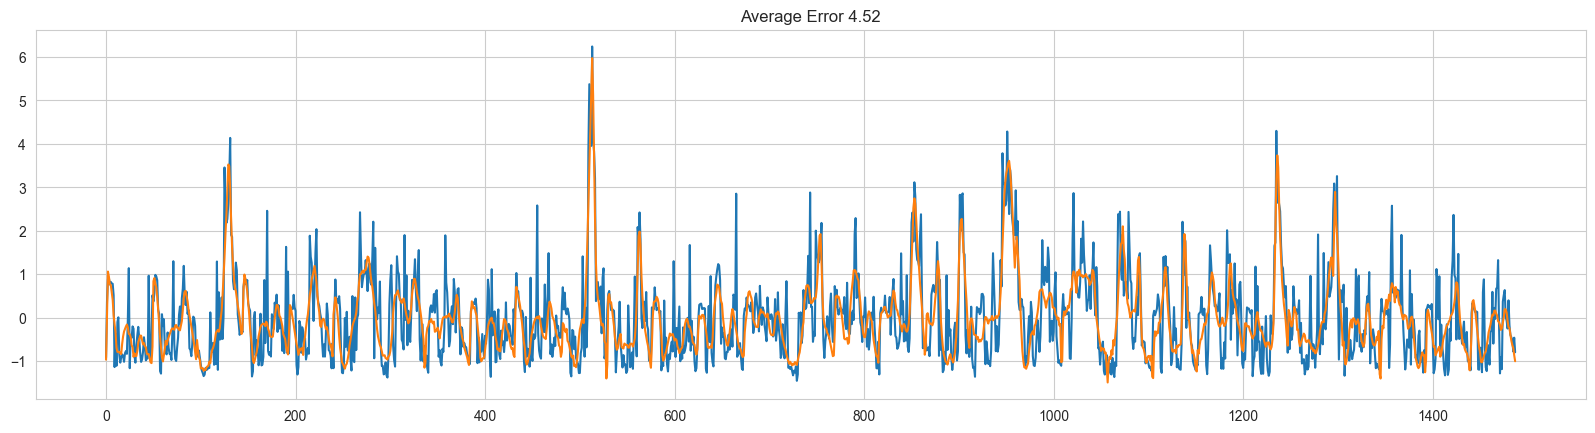

In [57]:
full_reconstruction_plot(394)

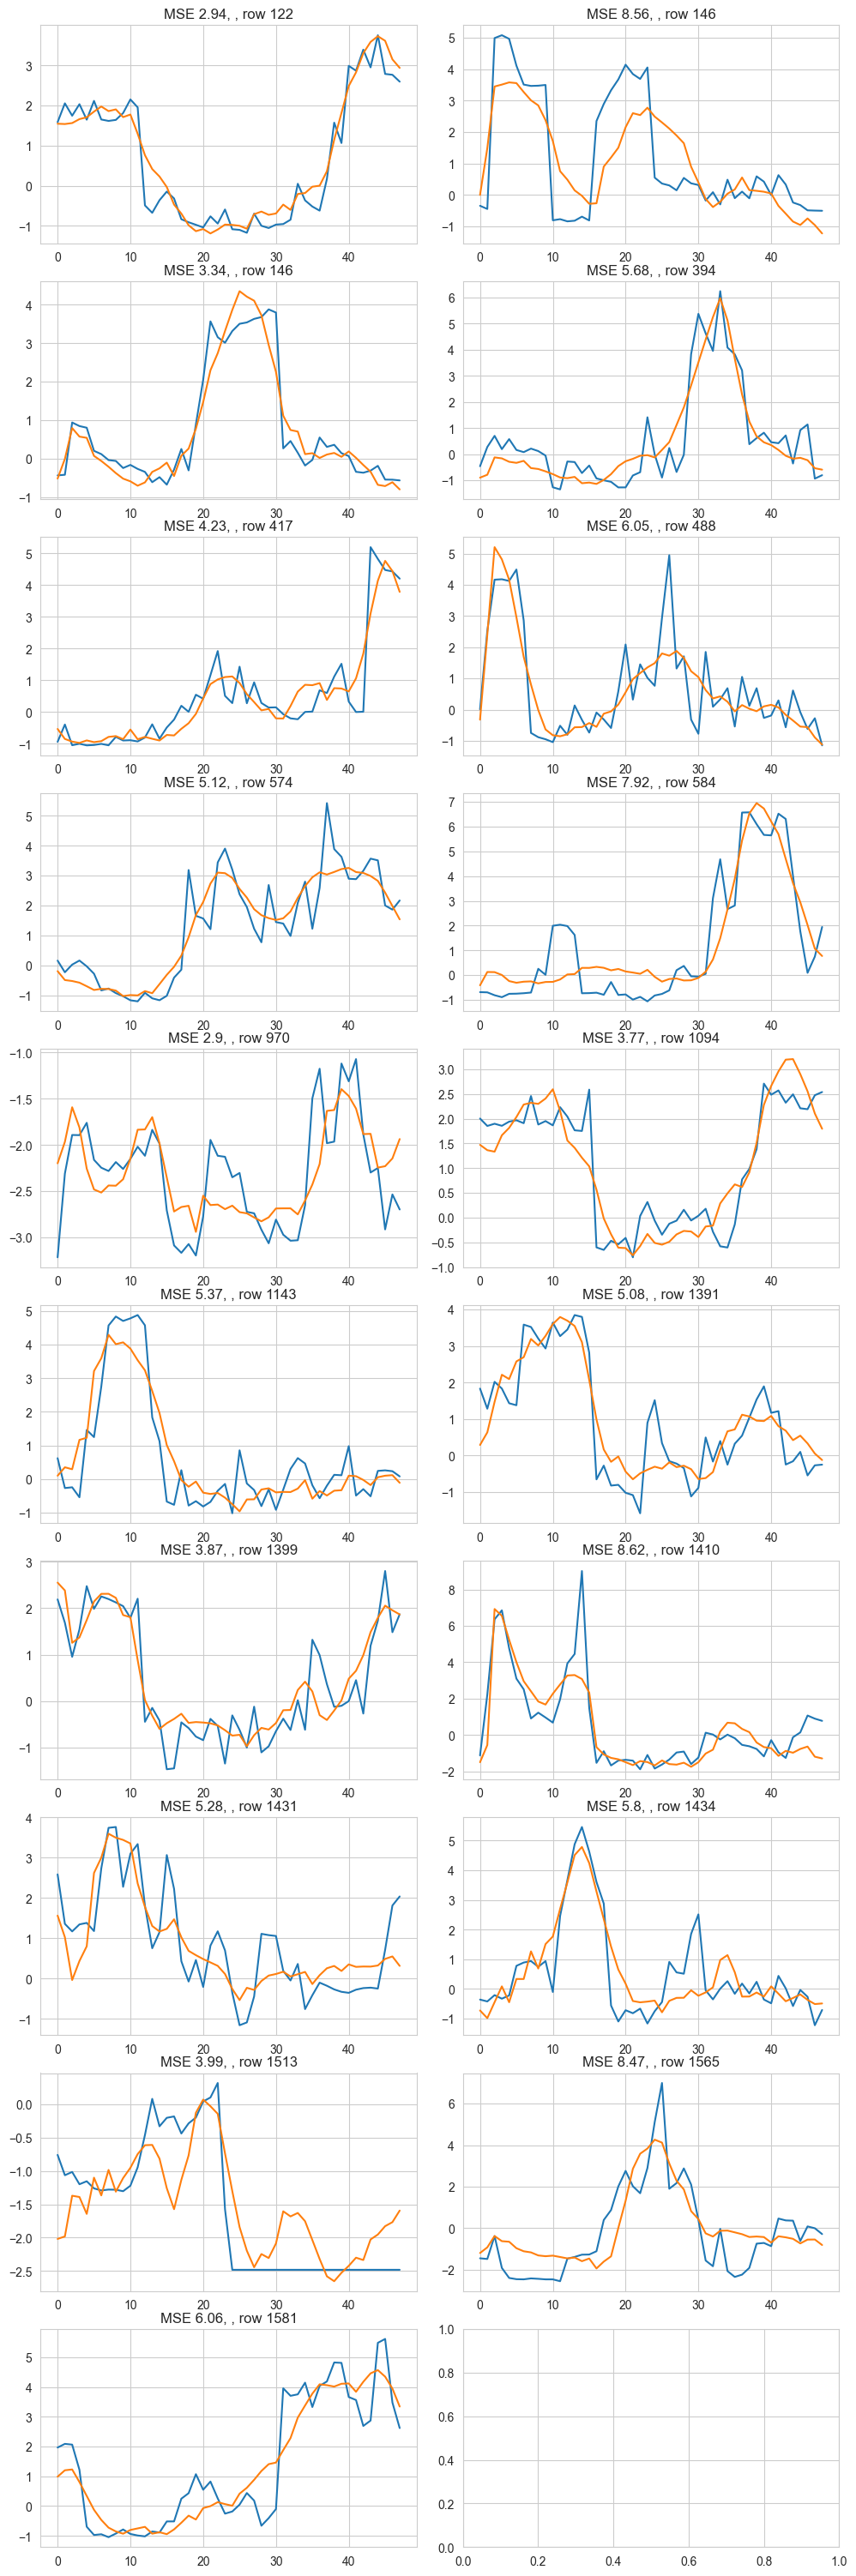

In [58]:
fig, axs = plt.subplots(10, 2, figsize=(10, 30))
plt.tight_layout()
for i in range(19):
    axs[i // 2, i % 2].plot(daily_data[anomalies_indices[i]])
    axs[i // 2, i % 2].plot(reconstructed_data[anomalies_indices[i]])
    axs[i // 2, i % 2].set_title(f'MSE {round(np.linalg.norm(daily_data[anomalies_indices[i]] - reconstructed_data[anomalies_indices[i]]), 2)}, , row {anomalies_indices[i] // 31}')
plt.show()

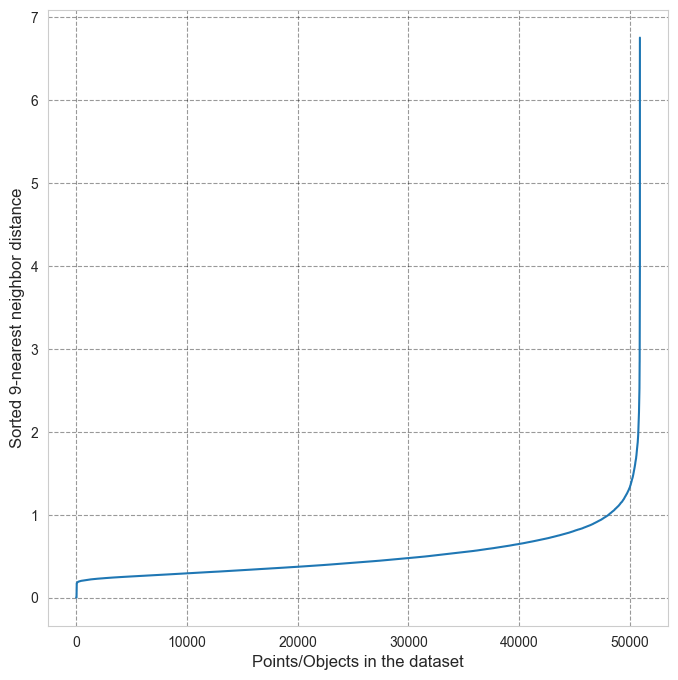

In [59]:
from sklearn.neighbors import NearestNeighbors


def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 
                                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()


k = 2 * encoded_data.shape[-1] - 1 # k=2*{dim(dataset)} - 1
get_kdist_plot(X=encoded_data, k=k)

In [60]:
# Создаем объект DBSCAN
dbscan_big = DBSCAN(eps=1, min_samples=9)

# Проводим кластеризацию данных
clusters_big = dbscan_big.fit_predict(encoded_data)

# Ищем объекты, отнесенные к кластеру -1 (это аномалии)
anomalies_indices_big = np.where(clusters_big == -1)[0]

In [61]:
np.unique(clusters_big, return_counts=True)

(array([-1,  0,  1], dtype=int64), array([ 1300, 49594,     8], dtype=int64))

In [62]:
len(anomalies_indices_big)

1300

In [63]:
# Преобразуем массив данных в DataFrame
df = pd.DataFrame(encoded_data, columns=['Dim1', 'Dim2', 'Dim3', 'Dim4', 'Dim5'])

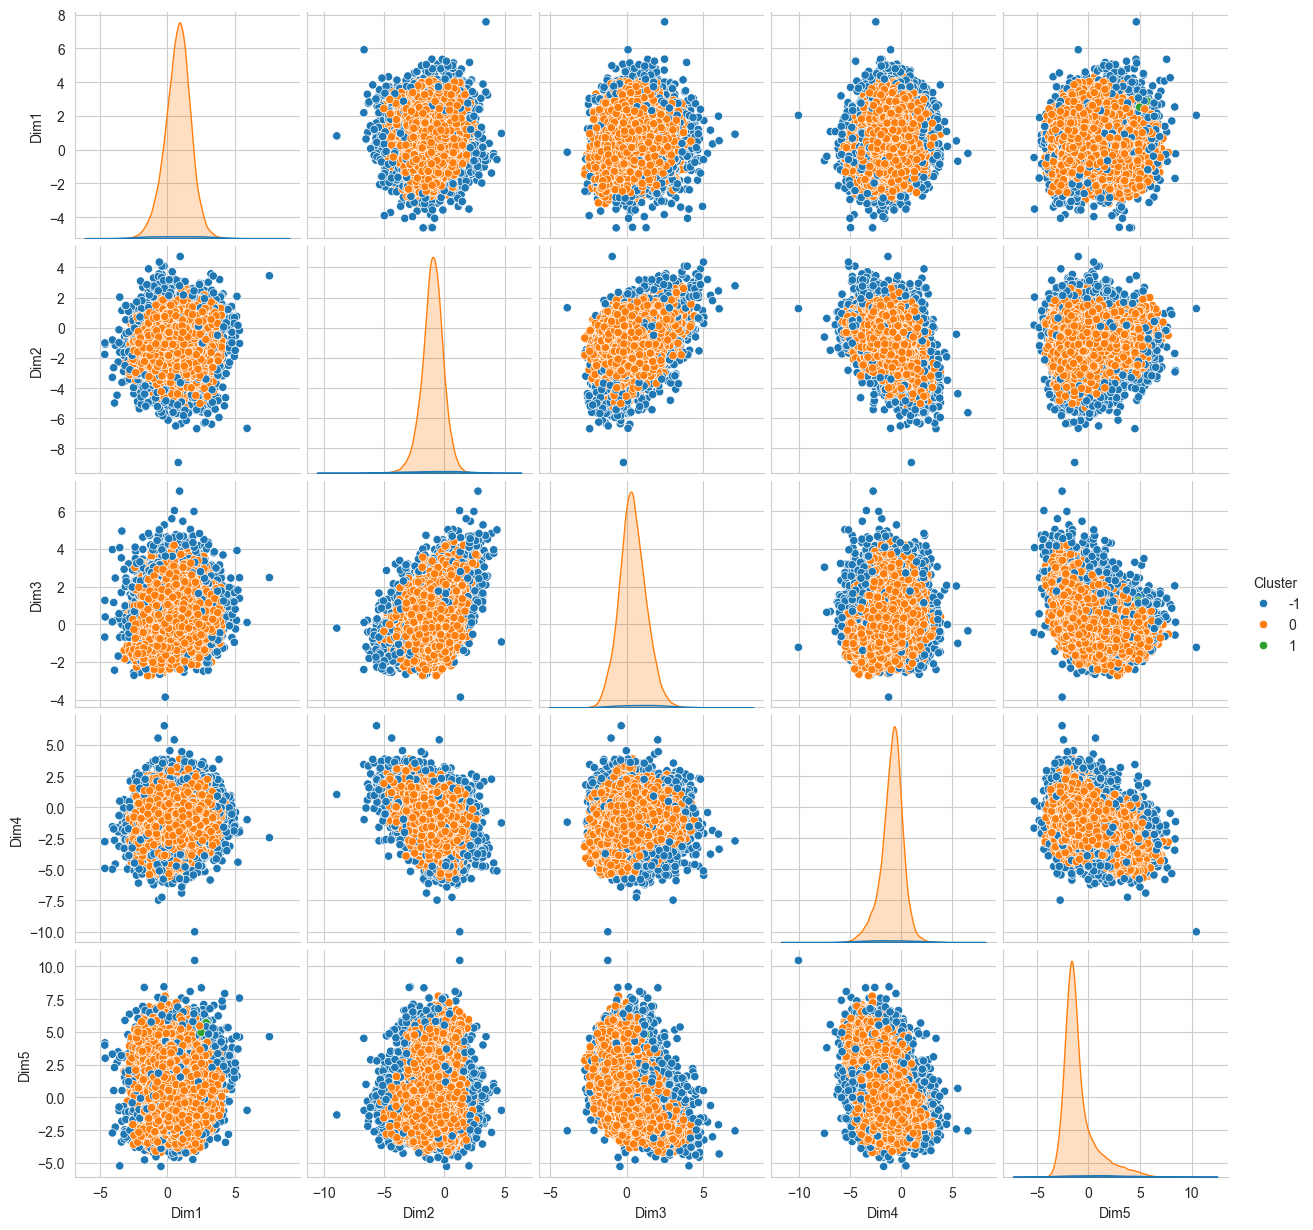

In [64]:
# Добавляем столбец 'Cluster', содержащий метки кластеров
df['Cluster'] = clusters_big

# Создаем pairplot, выделяя разные кластеры цветом
sns.pairplot(df, hue='Cluster', palette='tab10')
plt.show()

In [65]:
# Получаем уникальные значения и их частоты
unique_values, counts = np.unique(anomalies_indices_big // 31, return_counts=True)

# Сортируем значения по частоте встречаемости в порядке убывания
sorted_indices = np.argsort(-counts)
sorted_values = unique_values[sorted_indices]
sorted_counts = counts[sorted_indices]

<Axes: >

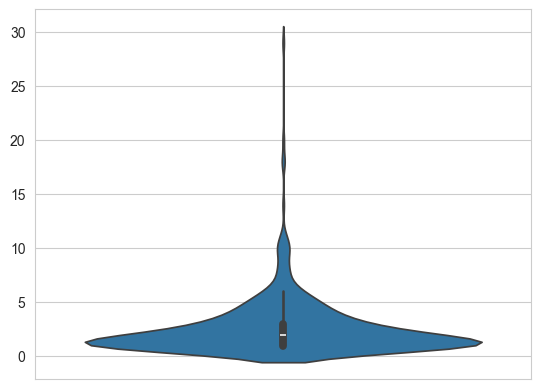

In [66]:
sns.violinplot(sorted_counts)

In [48]:
np.column_stack((sorted_values, sorted_counts))

array([[1620,   29],
       [1038,   20],
       [1239,   18],
       [1431,   18],
       [1000,   14],
       [ 898,   11],
       [ 690,   11],
       [ 689,   11],
       [ 921,   10],
       [1243,   10],
       [1238,   10],
       [1053,   10],
       [ 646,   10],
       [ 393,   10],
       [1569,    9],
       [1167,    9],
       [ 603,    9],
       [ 990,    8],
       [  65,    8],
       [ 970,    8],
       [ 429,    8],
       [ 122,    8],
       [1639,    7],
       [1543,    7],
       [ 146,    7],
       [ 433,    7],
       [1315,    7],
       [1094,    6],
       [1470,    6],
       [ 922,    6],
       [ 804,    6],
       [ 536,    6],
       [1486,    6],
       [1609,    6],
       [ 125,    6],
       [1211,    6],
       [ 446,    6],
       [1406,    6],
       [ 893,    6],
       [1633,    6],
       [ 661,    6],
       [1520,    6],
       [ 417,    5],
       [ 571,    5],
       [1271,    5],
       [1410,    5],
       [ 394,    5],
       [ 847,

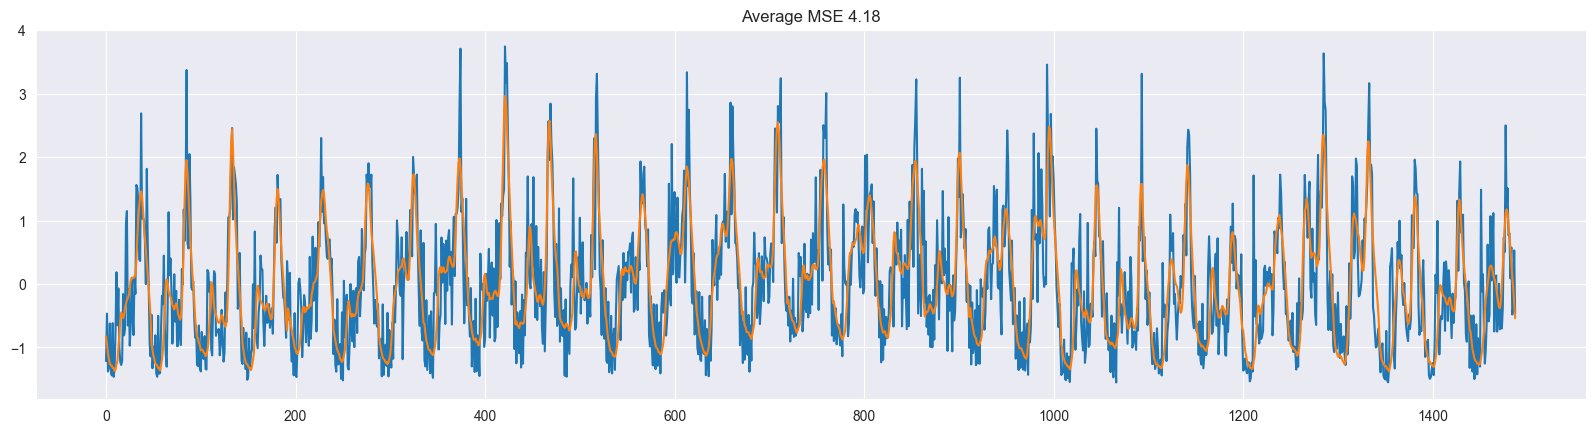

In [52]:
full_reconstruction_plot(100)

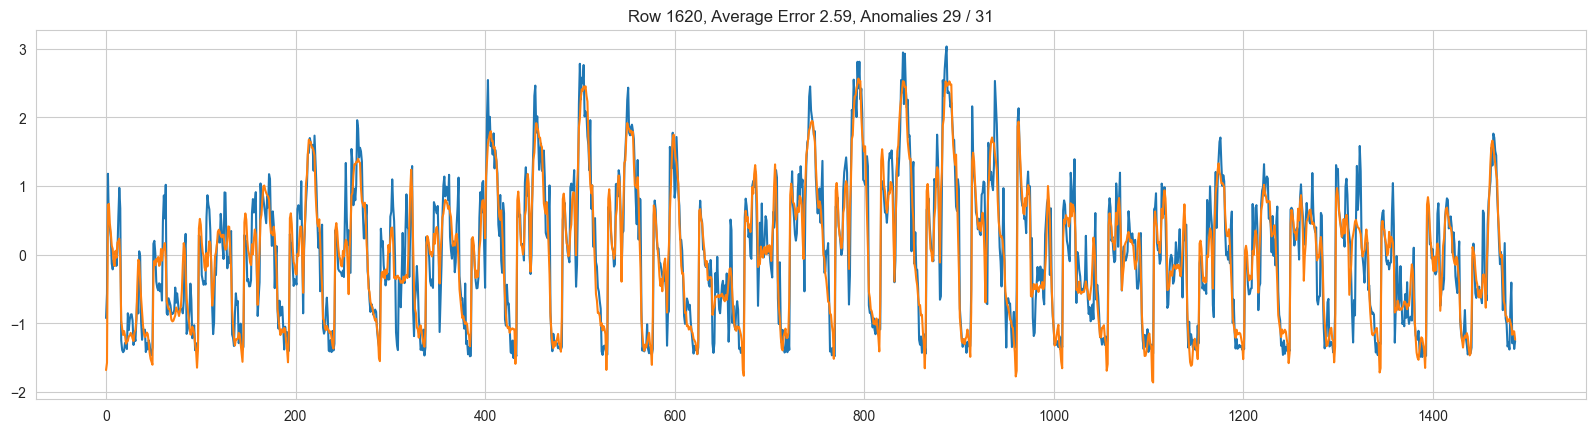

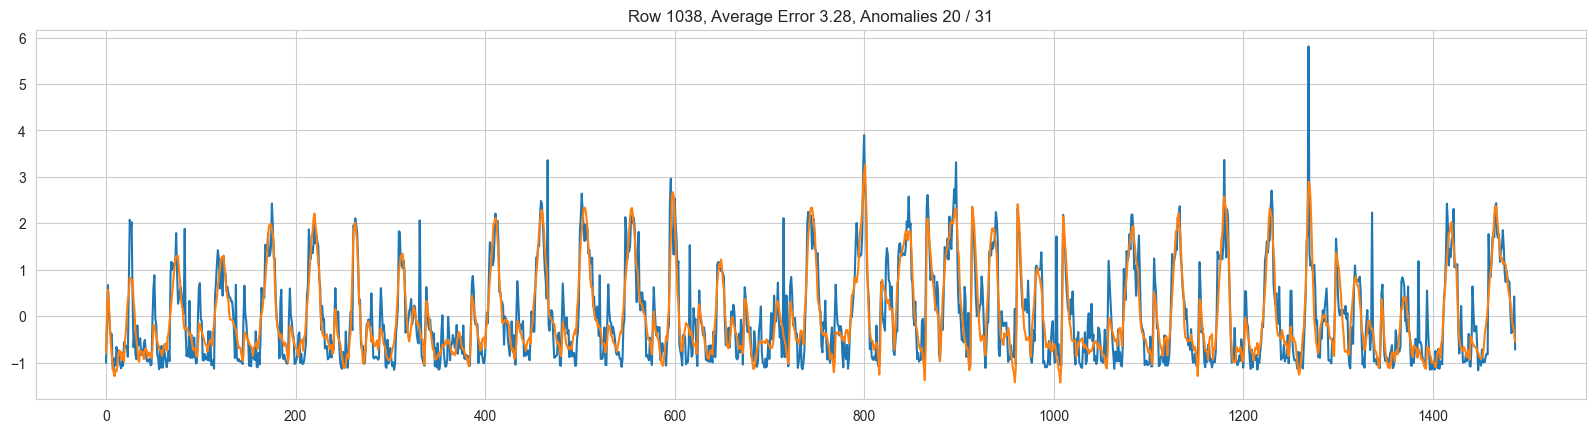

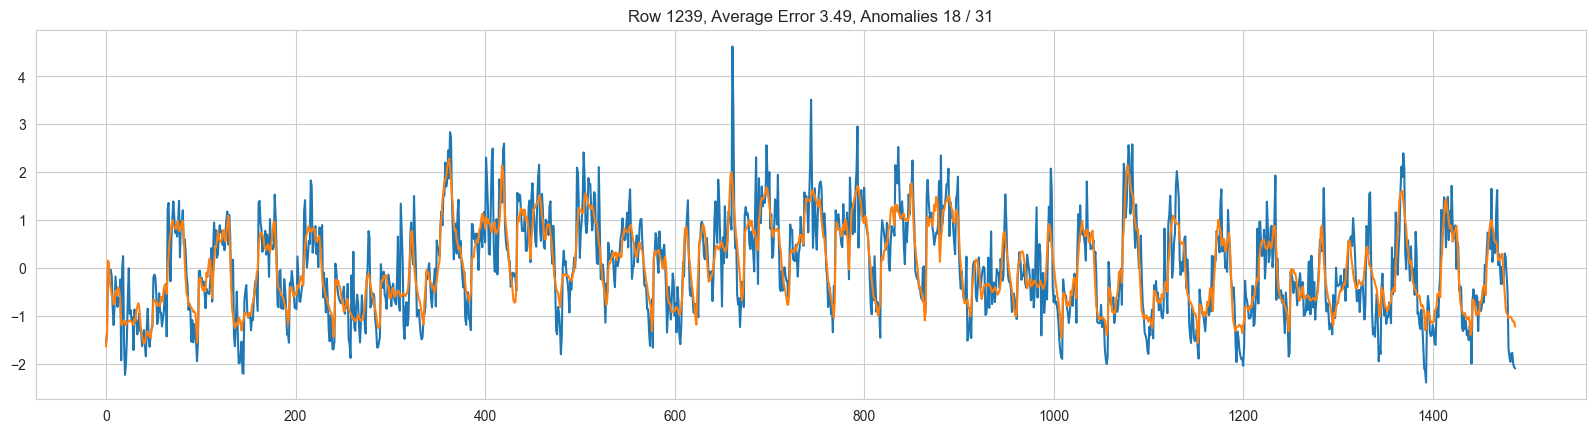

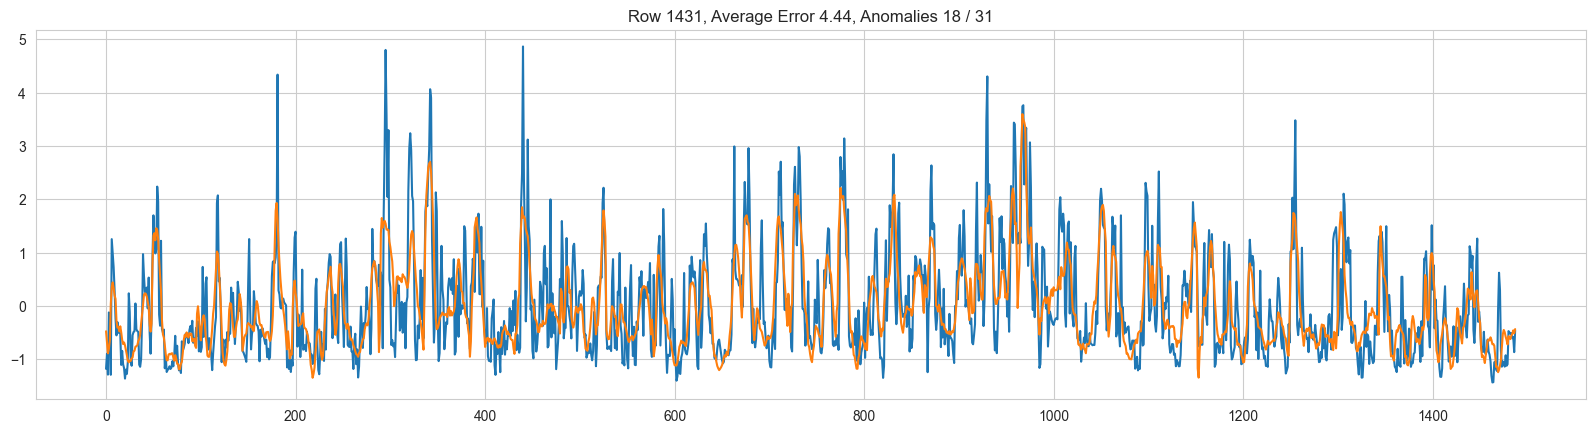

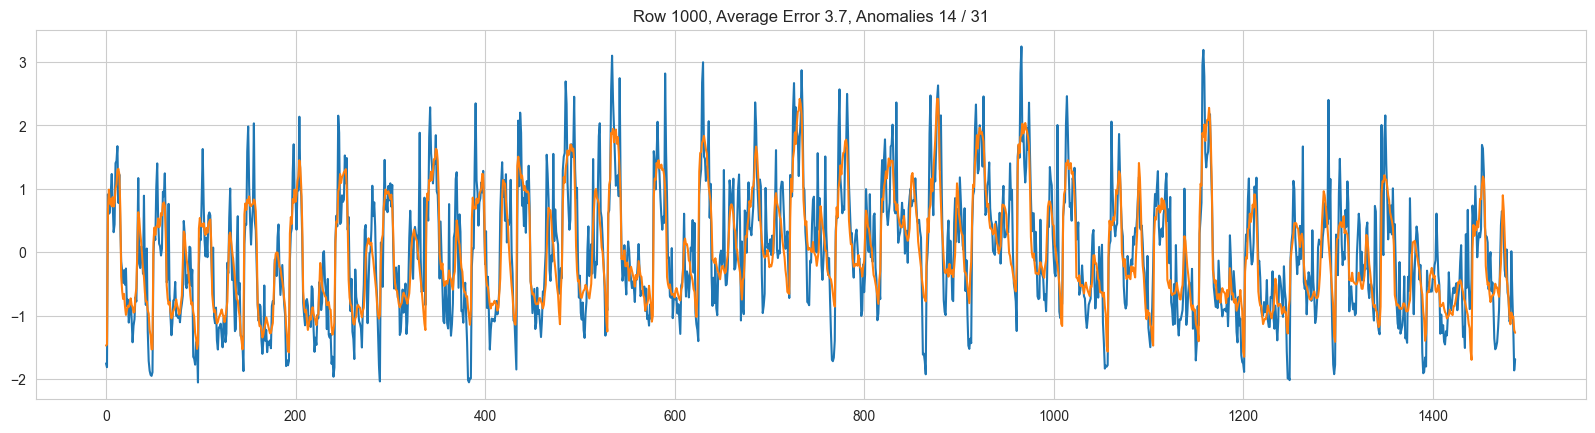

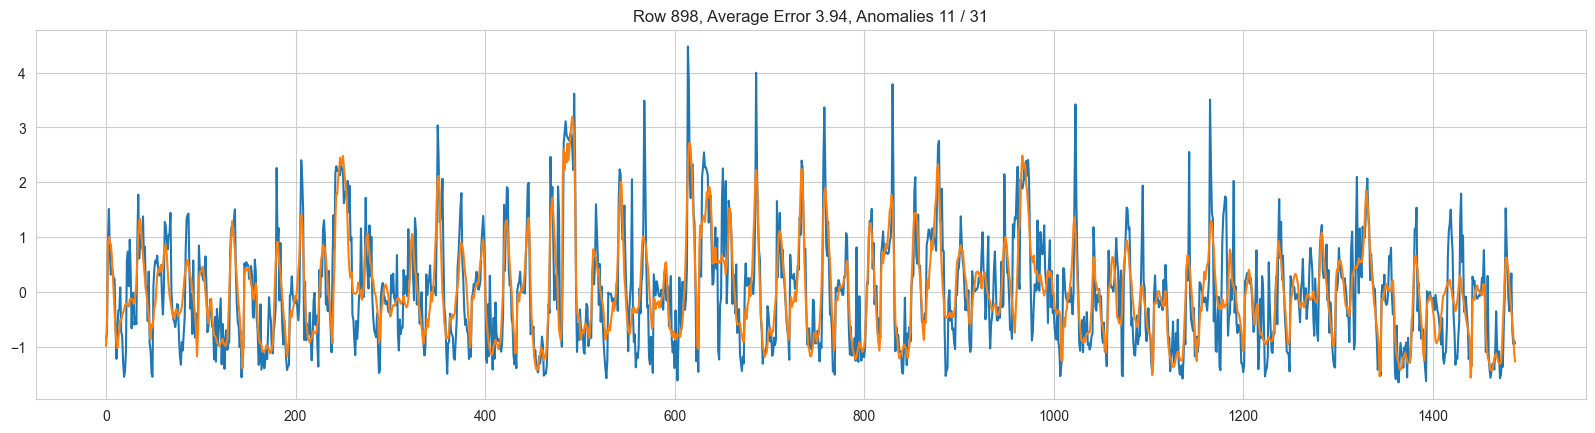

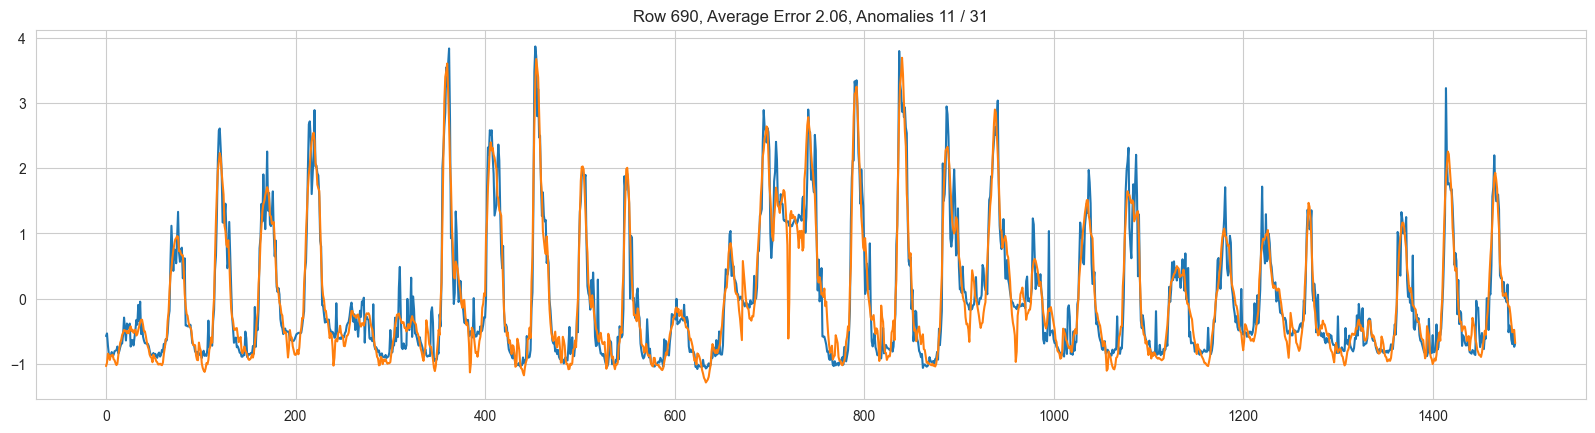

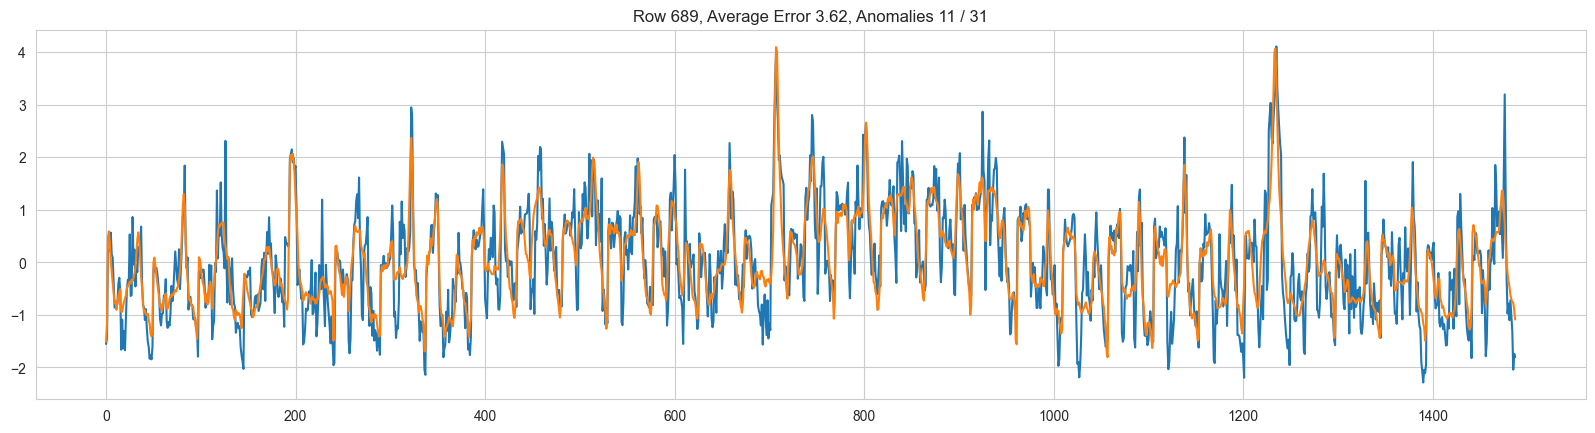

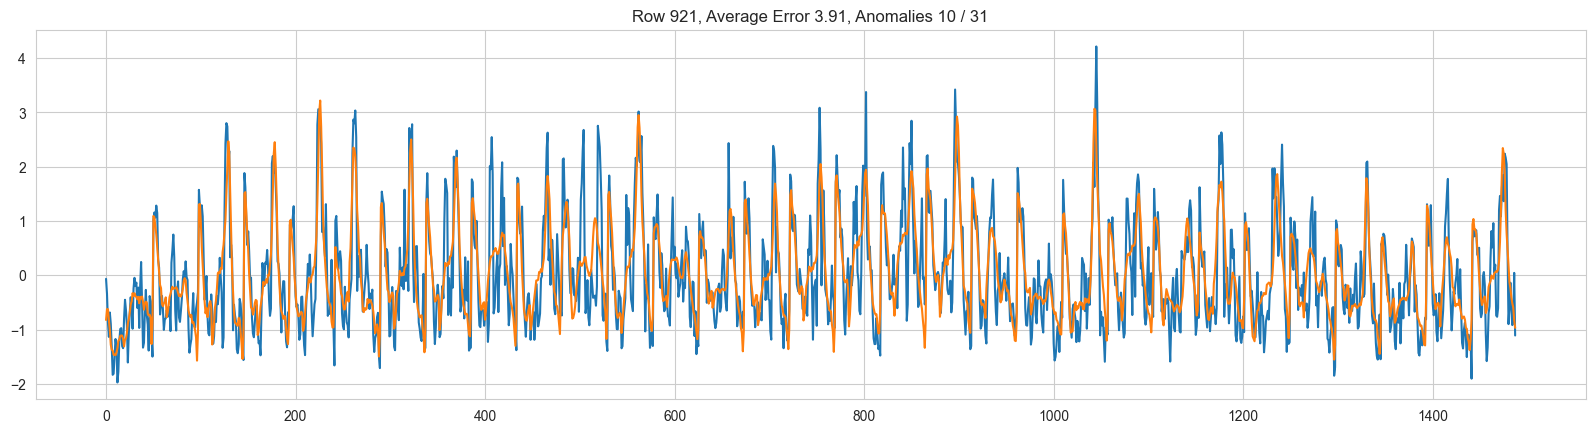

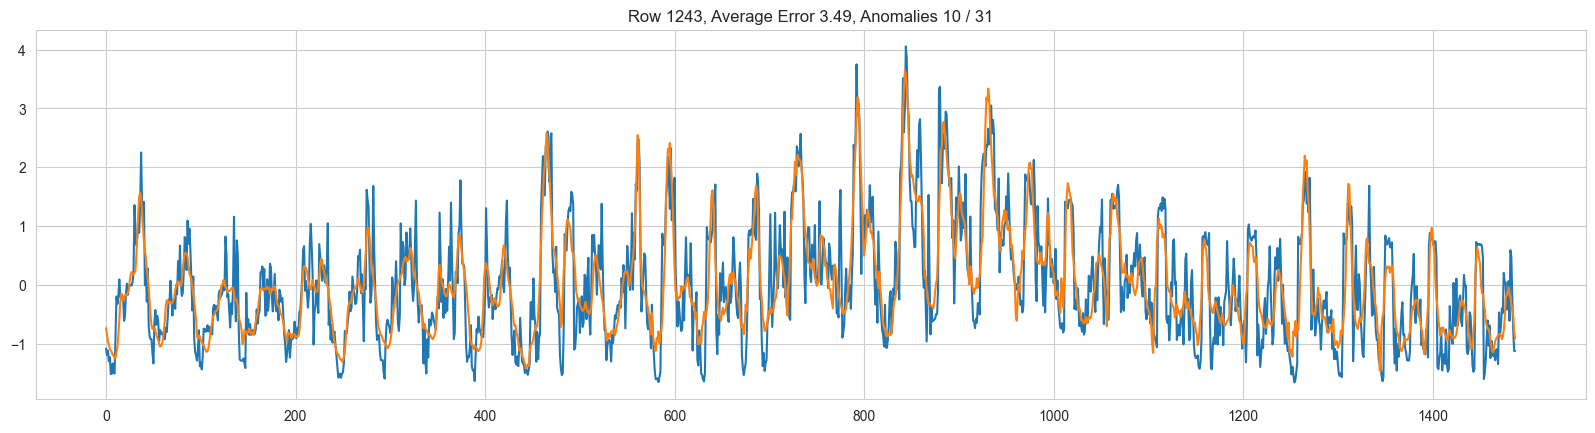

In [67]:
for i in range(10):
    plt.figure()
    full_reconstruction_plot(sorted_values[i])
    plt.gca().set_title(f'Row {sorted_values[i]}, ' + plt.gca().get_title() + f', Anomalies {sorted_counts[i]} / 31')